# Méthode de Régularisation : Lasso & Ridge 


Dans le domaine des mathématiques et des statistiques, et plus particulièrement dans le domaine de l'apprentissage automatique, la régularisation fait référence à un processus consistant à **ajouter de l'information à un problème pour éviter le surapprentissage. Cette information prend généralement la forme d'une pénalité envers la complexité du modèle.** D'un point de vue bayésien, l'utilisation de la régularisation revient à imposer une distribution a priori sur les paramètres du modèle. 

Avant de commencer, quelque consignes. 

### Objectifs 
Comprendre ces deux apporches en les appliquant sur un cas pratique : le pricing d'un appartement (pour changer) ! 

### Livrables 
Ce notebook complété avec les commentaire en conséquence (typiquement quand je demande que remarquez vous ? faite une phrase {sujet, verbe, complément} svp 


# La méthode Lasso 

En statistiques, le lasso est une méthode de contraction des coefficients de la régression développée par Robert Tibshirani dans **un article publié en 1996** intitulé [Regression shrinkage and selection via the lasso](https://pdfs.semanticscholar.org/1b65/af0b2847cf6edb1461eda659f08be27bc76d.pdf).

La méthode Lasso est très utilisé dans les 

Nous cherchons à expliquer de manière linéaire une variable $Y$ , par $p$ variables potentiellement explicatives $X_i$. Pour cela nous faisons $n$ observations et nous modèlisons la variable $Y$ de la manière suivante : $$Y=X \beta + \varepsilon$$

La question maintenant est de savoir quelle variable parmis les $p$ variables ont le plus de poids dans notre explicaton ! C'est donc l'objet de la méthode Lasso.    

Pour plus de détail je vous invite à consulter le cour de Pierre Gaillard et Anisse Ismaili, [Le Lasso, ou comment choisir parmi un grand nombre de variables à l'aide de peu d'observations](http://pierre.gaillard.me/doc/Ga09-report.pdf)


In [2]:
#importer vos libs 
import warnings
warnings.simplefilter("ignore")
import pandas as pd 
import numpy as np 
import seaborn as sns
import sklearn as sklearn

In [3]:
#importer votre dataset 
#commenter ce dataset 
# les types de variable
# la target 
# expliquer la difference entre les régressions linéaires simple et Lasso (et/ou Ridge )
df = pd.read_csv('../data/houseData.csv', sep=','); df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
#afficher les dimension de votre dataset 
df.shape

(21613, 21)

In [4]:
#enlever les colonnes non pertinentes 
df = df[['price','bedrooms','bathrooms', 'sqft_living', 'sqft_lot','floors','condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long','sqft_living15','sqft_lot15']]
df.shape

(21613, 17)

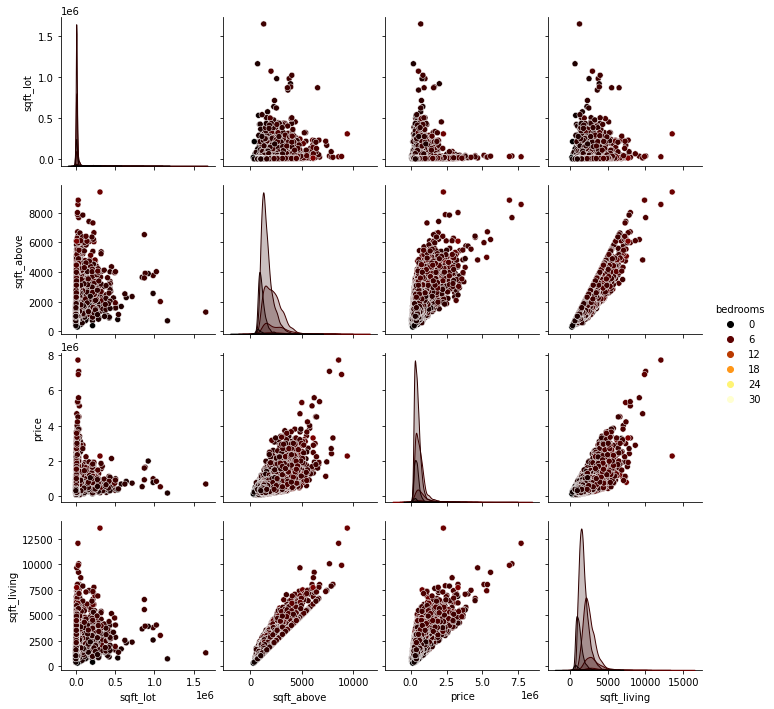

In [5]:
#faire pairplot en mettant en argument bedrooms afin de regarder l'impacte de cette variable  
#que remarquez vous ? 
sns.pairplot(df, hue= 'bedrooms', vars=['sqft_lot', 'sqft_above', 'price', 'sqft_living'], palette='afmhot')

In [6]:
#extraire les valeurs du prix (votre vecteur cible) dans une nouvelle variable et afficher sa taille
y = df[['price']]
y.size

21613

In [7]:
#supprimer la variable prix dans votre variable 
#pourquoi drop cette variable ?  
df = df.drop(columns='price')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21613 non-null  int64  
 1   bathrooms      21613 non-null  float64
 2   sqft_living    21613 non-null  int64  
 3   sqft_lot       21613 non-null  int64  
 4   floors         21613 non-null  float64
 5   condition      21613 non-null  int64  
 6   grade          21613 non-null  int64  
 7   sqft_above     21613 non-null  int64  
 8   sqft_basement  21613 non-null  int64  
 9   yr_built       21613 non-null  int64  
 10  yr_renovated   21613 non-null  int64  
 11  zipcode        21613 non-null  int64  
 12  lat            21613 non-null  float64
 13  long           21613 non-null  float64
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 2.6 MB


In [9]:
#créer une votre varible de travail X 
#rappel : il faut que ce soit un objet numpy ! 
X = df
X.values

array([[ 3.00000e+00,  1.00000e+00,  1.18000e+03, ..., -1.22257e+02,
         1.34000e+03,  5.65000e+03],
       [ 3.00000e+00,  2.25000e+00,  2.57000e+03, ..., -1.22319e+02,
         1.69000e+03,  7.63900e+03],
       [ 2.00000e+00,  1.00000e+00,  7.70000e+02, ..., -1.22233e+02,
         2.72000e+03,  8.06200e+03],
       ...,
       [ 2.00000e+00,  7.50000e-01,  1.02000e+03, ..., -1.22299e+02,
         1.02000e+03,  2.00700e+03],
       [ 3.00000e+00,  2.50000e+00,  1.60000e+03, ..., -1.22069e+02,
         1.41000e+03,  1.28700e+03],
       [ 2.00000e+00,  7.50000e-01,  1.02000e+03, ..., -1.22299e+02,
         1.02000e+03,  1.35700e+03]])

In [10]:
#enregistrer le nom de vos colonnes dans une list 
columns = X.columns.tolist()
columns

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [11]:
#créer un 'Lasso estimator'
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
X_train, X_test, y_train, y_test = train_test_split( X, y)

In [12]:
#fiter sur votre ensemble de donnée 
clf.fit(X, y)

Lasso(alpha=0.2, normalize=True)

In [13]:
#afficher les coefficients
coef = clf.coef_
print(coef)

[-4.60371681e+04  4.27861001e+04  2.09910162e+02  1.55917506e-01
  1.10125833e+04  2.91820514e+04  1.01162856e+05 -2.23999188e+01
 -3.02780899e+01 -2.82963779e+03  3.48449523e+01 -4.76908000e+02
  5.55627700e+05 -2.51484241e+05  4.00319113e+01 -3.23987600e-01]


<AxesSubplot:>

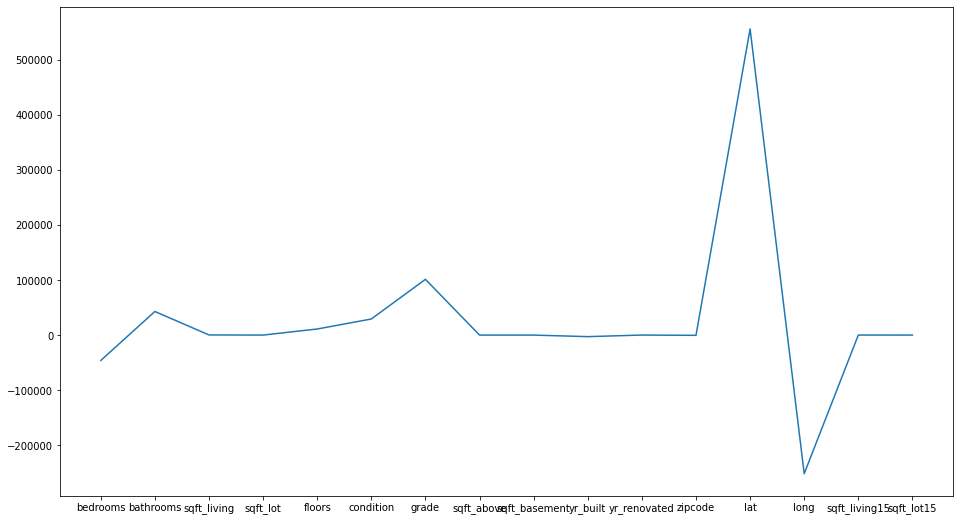

In [14]:
#ploter les coefficients avec les bon noms
#que remarquez vous ? 
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
coef = pd.Series(coef, columns)
sns.lineplot(x=coef.index, y=coef)

In [15]:
#essayer lasso avec un alpha = 100 et afficher les coefs
#que remarquez vous ? 
clf1 = linear_model.Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
clf1.fit(X, y)
coef1 = clf1.coef_
print(coef1)

[-2.21651222e+03  3.76966686e+03  1.70151388e+02  0.00000000e+00
  0.00000000e+00  1.01307729e+04  1.02366456e+05  0.00000000e+00
  0.00000000e+00 -1.94583213e+03  1.53104933e+01 -0.00000000e+00
  4.70758627e+05 -7.68871412e+04  2.19537362e+01 -0.00000000e+00]


<AxesSubplot:>

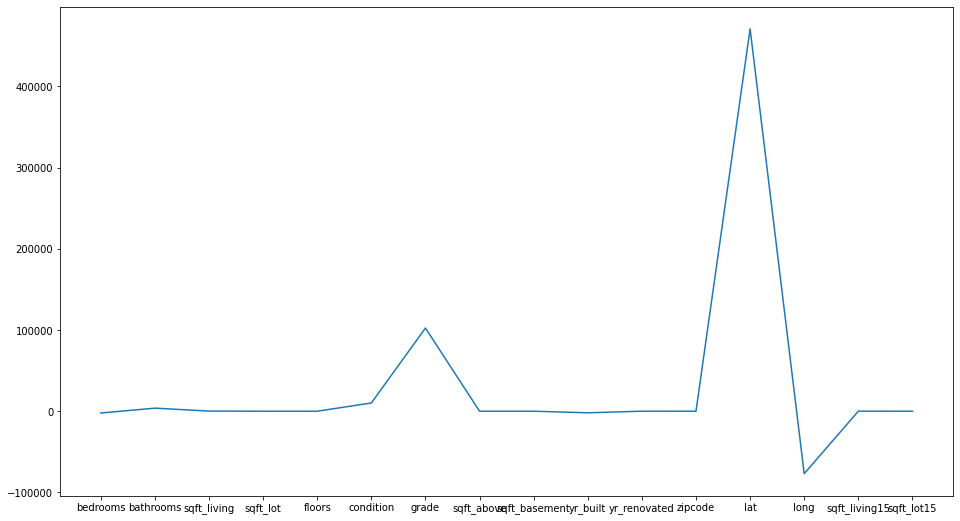

In [16]:
#afficher la courbe 
plt.figure(figsize=(16, 9))
coef1 = pd.Series(coef1, columns)
sns.lineplot(x=coef1.index, y=coef1)

In [17]:
#pareil avec un alpha = 1000 et afficher les coefs
#que remarquez vous cette fois ci? 
clf2 = linear_model.Lasso(alpha=1000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
clf2.fit(X, y)
coef2 = clf2.coef_
print(coef2)

[    0.             0.            93.61923199     0.
     0.             0.         27594.4045107      0.
     0.            -0.             0.             0.
     0.            -0.             0.             0.        ]


<AxesSubplot:>

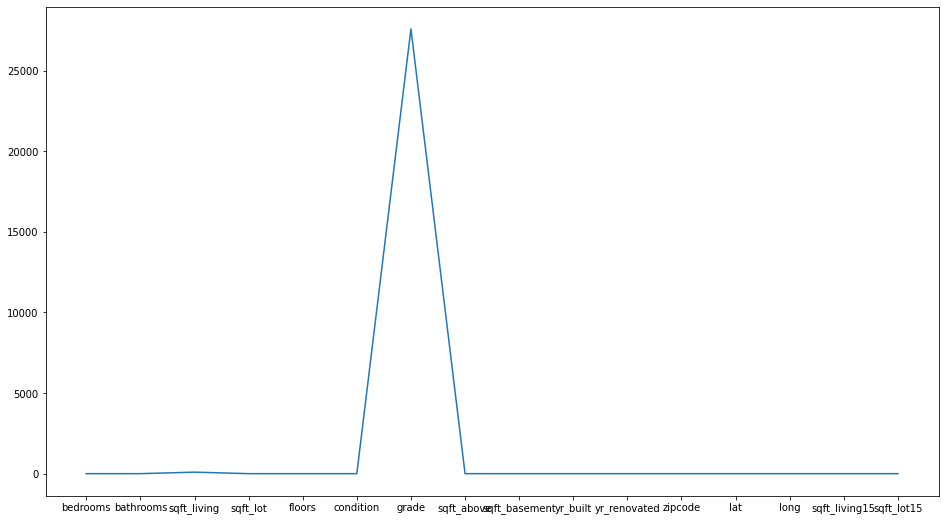

In [18]:
#afficher la courbe 
plt.figure(figsize=(16, 9))
coef2 = pd.Series(coef2, columns)
sns.lineplot(x=coef2.index, y=coef2)

## La cross validation 
La validation croisée (ou cross-validation) est en apprentissage automatique, une méthode d’estimation de fiabilité d’un modèle fondé sur une technique d’échantillonnage. 

**Rechercher ce qu'est une cross-validation et faite appliquer la sur votre dataset, afficher votre score moyen pour 5 itérations**

In [19]:
#afficher votre tableau de cross validation ainsi que la moyenne 

scores = cross_val_score(clf, X, y).mean()
print("Average 5-Fold CV Score: {}".format(scores))

Average 5-Fold CV Score: 0.6578810832739277


# Régressions Régularisées

La régularisation consiste à introduire une notion de pénalité dans notre manière de mesurer l'érreur (la somme des erreurs au carré pour nous) cela nous permet donc d'inférer sur nos paramètres. Il faut ajuster ce terme de régularisation dans le but d’obtenir un modèle de meilleure qualité. 

La régularisation de Tikhonov, plus connue sous le nom de **"ridge regression"** est une méthode qui consiste à ajouter une contrainte sur les coefficients lors de la modélisation pour maîtriser l’amplitude de leurs valeurs (« pour éviter qu’elles partent dans tous les sens »)

On va donc essayé d'appliquer Ridge sur nos données.

In [94]:
#définir un range de 50 valeur de 10-4 à 1 avec la fonction logspace  
#que fait la fonction logspace de numpy? 
alpha = np.logspace(-4, 0)
alpha

array([1.00000000e-04, 1.20679264e-04, 1.45634848e-04, 1.75751062e-04,
       2.12095089e-04, 2.55954792e-04, 3.08884360e-04, 3.72759372e-04,
       4.49843267e-04, 5.42867544e-04, 6.55128557e-04, 7.90604321e-04,
       9.54095476e-04, 1.15139540e-03, 1.38949549e-03, 1.67683294e-03,
       2.02358965e-03, 2.44205309e-03, 2.94705170e-03, 3.55648031e-03,
       4.29193426e-03, 5.17947468e-03, 6.25055193e-03, 7.54312006e-03,
       9.10298178e-03, 1.09854114e-02, 1.32571137e-02, 1.59985872e-02,
       1.93069773e-02, 2.32995181e-02, 2.81176870e-02, 3.39322177e-02,
       4.09491506e-02, 4.94171336e-02, 5.96362332e-02, 7.19685673e-02,
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00])

In [90]:
#créer 2 tableaux pour stocker les résultat 
# un tableau pour le scrore moyen de la cross-validation (10 epoch)
# un tableau pour la variance moyenne 
score_mean = []
var_mean = []

In [91]:
#instancier un 'Ridge estimator' normalisé 
#A quoi sert la normalisation ? 
from sklearn.linear_model import Ridge
clf_ridge = Ridge(normalize=True)

In [93]:
#faire une boucle sur les alpha 
# --> but : voir l'effet du paramètre alpha sur l'accuracy   
#
#        INDICE 
#
# pour chaque alpha faite 10 cross-validation 
# ajouter les résultats à vos tableaux 
#que remarquez vous ? 
from sklearn.metrics import r2_score
for i in alpha:
    clf_ridge.alpha = i
    scores = cross_val_score(clf_ridge, X, y, cv=10).mean()
    var = np.std(cross_val_score(clf_ridge, X, y, cv=10))
    score_mean.append(scores)
    var_mean.append(var)

In [85]:
np.mean(score_mean)
len(score_mean)

50

In [86]:
np.mean(var_mean)

0.017398192410569082

In [87]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha[0], alpha[-1]])
    ax.set_xscale('log')
    plt.show()

Utiliser la fonction ci-dessous, expliquer la et commenter le résultat : 
```python
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()


```

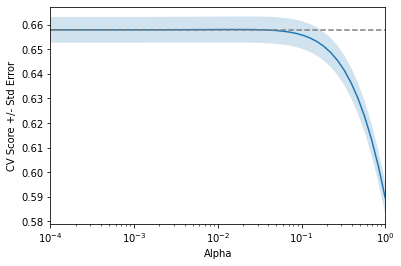

In [88]:
display_plot(score_mean, var_mean)

In [24]:
#que remarquez vous par rapport au coefficient alpha ? 
